In [1]:

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=6cf7f764f5f92c74a483e91868eff45f8d76f16c6f9f00c7d62507d270bc18b2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 35 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additi

# ASR

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically **transcribe spoken language (speech-to-text)**. Our goal is usually to have a model that minimizes the Word Error Rate (WER) metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. If you are not using Google Colab, please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step--see the "Downloads" section of the linked Sox homepage. (If you are using Google Colab, Sox should have already been installed in the setup cell at the beginning.)

In [2]:
import glob
import os
import subprocess
import tarfile
import wget
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)


# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [3]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

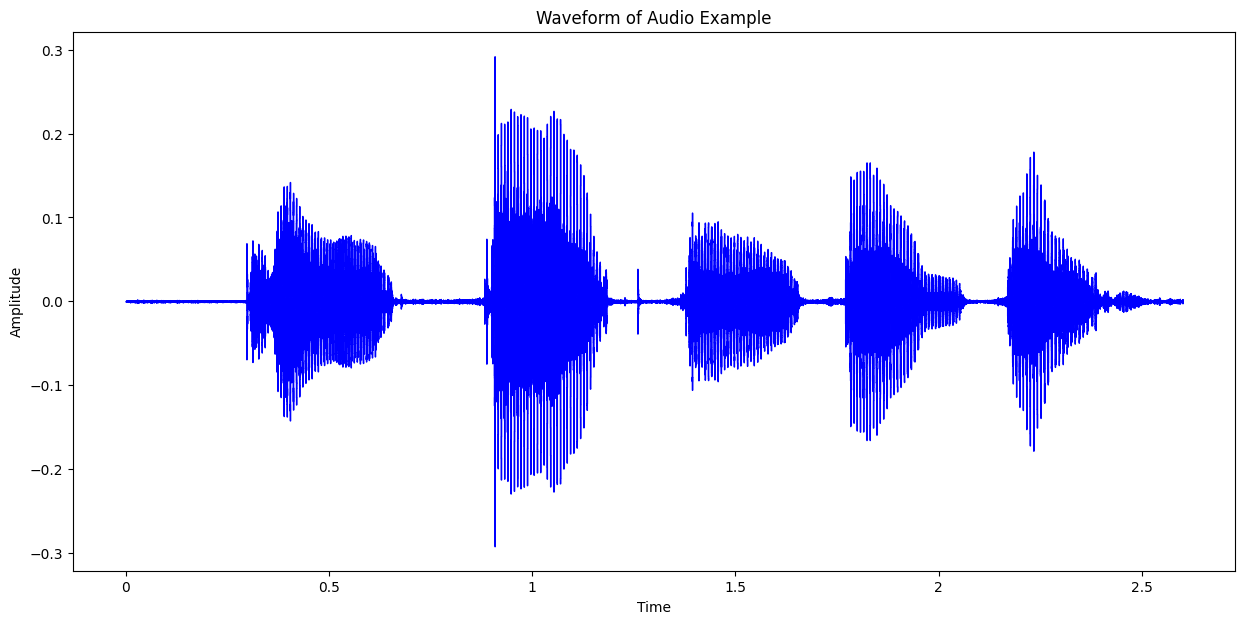

In [4]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

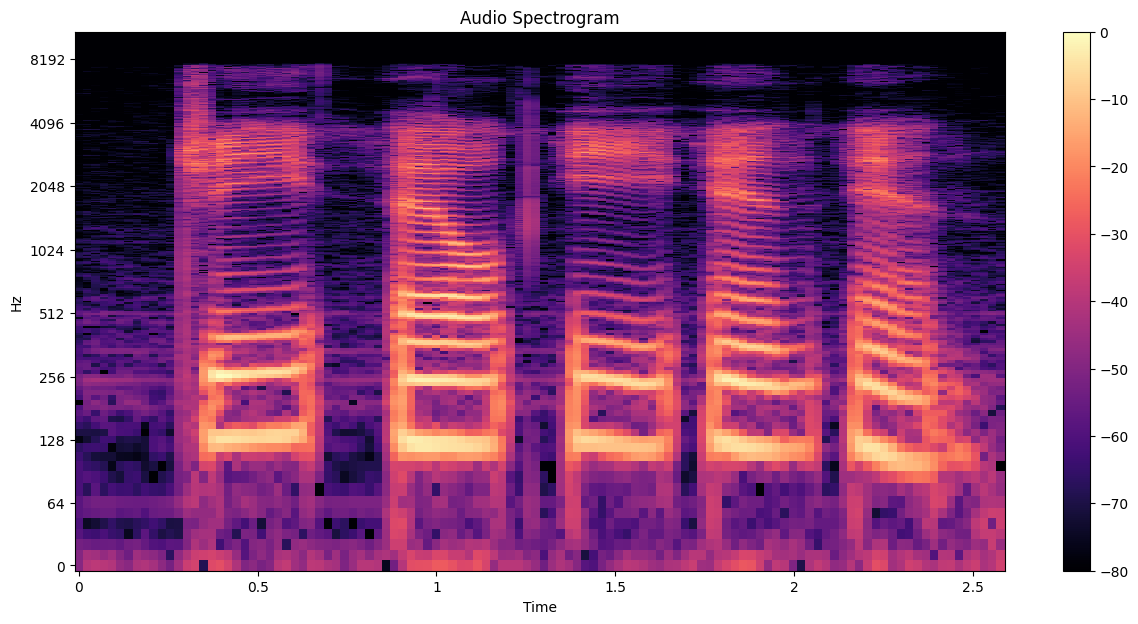

In [5]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

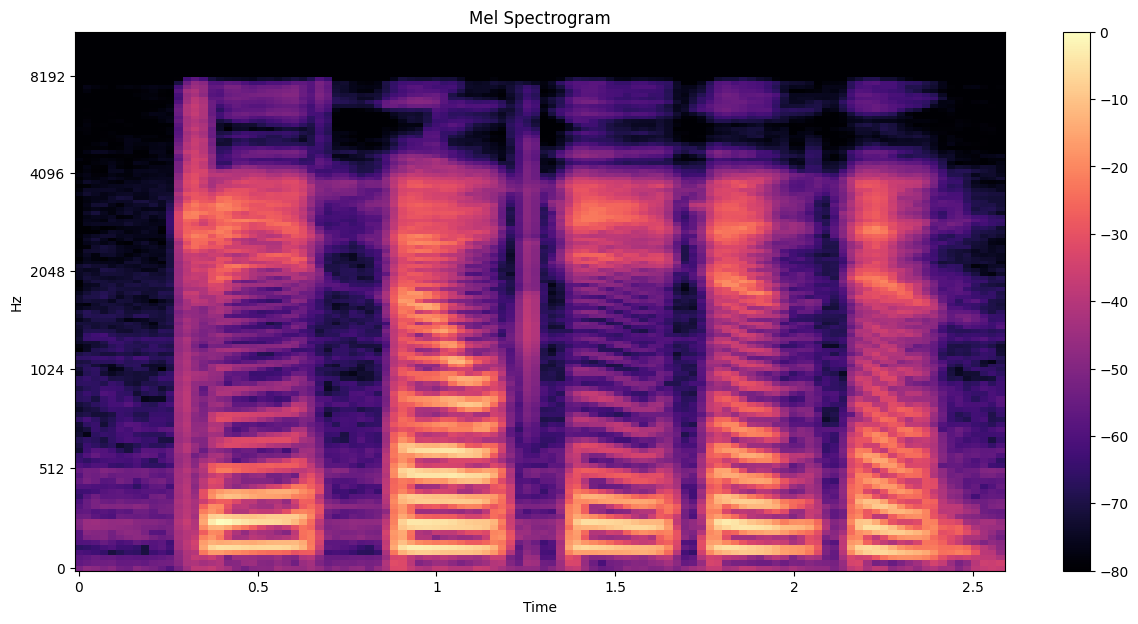

In [6]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

# Using NeMo for Automatic Speech Recognition

Now that we have an idea of what ASR is and how the audio data looks like, we can start using NeMo to do some ASR!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. NeMo also comes with complete models which only require your data and hyperparameters for training.

In [7]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

## Using an Out-of-the-Box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet15x5 model.

To achieve this we will use ``` from_pretrained() ``` method. However, you may use .nemo model files and ```restore_from() ``` methods.

In [8]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you otherwise use restore_from()
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-02-25 14:54:16 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-02-25 14:54:18 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-02-25 14:54:19 features:289] PADDING: 16
[NeMo I 2024-02-25 14:54:20 save_restore_connector:263] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Next, we'll simply add paths to files we want to transcribe into the list and pass it to our model. Note that it will work for relatively short (<25 seconds) files.

In [9]:
files = [os.path.join(data_dir, 'an4/wav/an4_clstk/mgah/cen2-mgah-b.wav')]
for fname, transcription in zip(files, quartznet.transcribe(files)):
  print(f"\nAudio in {fname} was recognized as: {transcription}")

Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Audio in ./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


# Basic homework
Conduct ASR in Russian language. Use your microphone to record input data. Use Russian language.

The following cell will download suggested model.

In [10]:
import tarfile
import wget
import os
# imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

def download(url, out_path):
  data_dir = '.'
  if not os.path.exists(data_dir):
      os.makedirs(data_dir)
  if not os.path.exists(os.path.join(data_dir, out_path)):
      golos_path = wget.download(url, os.path.join(data_dir, out_path))
      print(f"Model downloaded at: {golos_path}")
  else:
      print("already exists.")
      golos_path = os.path.join(data_dir, out_path)

class AudioSignal:
  """
  SOUND RECORDER
  """
  @staticmethod
  def __record(file_name, sec=3):
    RECORD = """
    const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader()
      reader.onloadend = e => resolve(e.srcElement.result)
      reader.readAsDataURL(blob)
    })
    var record = time => new Promise(async resolve => {
      stream = await navigator.mediaDevices.getUserMedia({ audio: true })
      recorder = new MediaRecorder(stream)
      chunks = []
      recorder.ondataavailable = e => chunks.push(e.data)
      recorder.start()
      await sleep(time)
      recorder.onstop = async ()=>{
        blob = new Blob(chunks)
        text = await b2text(blob)
        resolve(text)
      }
      recorder.stop()
    })
    """
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    audio = AudioSegment.from_file(BytesIO(b))
    audio.export(file_name, format='wav', parameters=["-ar", "8000"])
    return audio

  def __init__(self, file_name):
    self.sample_rate = 8000
    self.file_name = file_name

  def record(self, sec):
    self.audioSegment = self.__record(self.file_name, sec)
    return self.audioSegment

In [11]:
golos_url = 'https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/QuartzNet15x5_golos.nemo'
model_path = 'QuartzNet15x5_golos.nemo'
download(golos_url, model_path)

Model downloaded at: ./QuartzNet15x5_golos.nemo


In [ ]:
#FILL IN MODEL INITIALIZATION
nemo_asr.models.EncDecCTCModel.list_available_models()
ru_model = nemo_asr.models.EncDecCTCModel.restore_from(restore_path="QuartzNet15x5_golos.nemo")


In [44]:
audioSignal = AudioSignal(file_name='audio_a.wav')
audioSignal.record(sec=2)

<IPython.core.display.Javascript object>

In [45]:
#FILL IN TRANSCRIPTION
custom_output = 'привет'

In [46]:
print(custom_output)

привет


# Advanced homework

In [15]:
dataset_url = "https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/test.tar"
dataset_path = "dataset.tar"
download(dataset_url, dataset_path)

Model downloaded at: ./dataset.tar


In [ ]:
nemo_asr.models.EncDecCTCModelBPE.list_available_models()

In [51]:
asr_model = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_ru_conformer_ctc_large")

[NeMo I 2024-02-25 17:03:01 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_ru_conformer_ctc_large/85481989be8cfb2f92a5bb9946b8da5c/stt_ru_conformer_ctc_large.nemo.
[NeMo I 2024-02-25 17:03:01 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_ru_conformer_ctc_large/85481989be8cfb2f92a5bb9946b8da5c/stt_ru_conformer_ctc_large.nemo
[NeMo I 2024-02-25 17:03:01 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-02-25 17:03:08 mixins:172] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2024-02-25 17:03:08 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: ''
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    
[NeMo W 2024-02-25 17:03:08 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 16
    shuffle: false
    num_workers: 8
    pin_

[NeMo I 2024-02-25 17:03:08 features:289] PADDING: 0
[NeMo I 2024-02-25 17:03:11 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/stt_ru_conformer_ctc_large/85481989be8cfb2f92a5bb9946b8da5c/stt_ru_conformer_ctc_large.nemo.


In [ ]:
!tar -xvf dataset.tar

In [17]:
import json

def extract_data(subset_path):
  gt_path = os.path.join(subset_path, "manifest.jsonl")

  gt_list_paths = []
  gt_list_transcriptions = []
  with open(gt_path, "r") as f:
      for line in f:
          sample_dict = json.loads(line)
          gt_list_paths.append(os.path.join(subset_path, sample_dict["audio_filepath"]))
          gt_list_transcriptions.append(sample_dict["text"])
  return gt_list_paths, gt_list_transcriptions

In [18]:
subset1, subset2 = "./test/farfield", "./test/crowd"
gt_list_paths_farfield, gt_list_transcriptions_farfield = extract_data(subset1)
xgt_list_paths_crowd, gt_list_transcriptions_crowd = extract_data(subset2)


In [50]:
print(asr_model.transcribe("audio_a.wav"))

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]

['привет']


Use Russian language ASR model to transcribe dataset

In [ ]:
#FILL IN FARFIELD OUTPUTS
farfield_outputs = [asr_model.transcribe(audio) for audio in gt_list_paths_farfield]

In [ ]:
for predicted, label in zip(farfield_outputs, gt_list_transcriptions_farfield):
  print(predicted, " ", label)

In [ ]:
crowd_outputs = [asr_model.transcribe(audio) for audio in xgt_list_paths_crowd]

In [39]:
print(len(xgt_list_paths_crowd))
print(len(gt_list_paths_farfield))

9994
1916


In [40]:
for predicted, label in zip(crowd_outputs, gt_list_transcriptions_crowd):
  print(predicted, " ", label)

Streaming output truncated to the last 5000 lines.
['тнт клаб']   тнт клаб
['шерлок семнадцатая серия']   шерлок семнадцатая серия
['пять восемьсот пятьдесят девять двести тридцать восемь пятьдесят семь двенадцать']   пять восемьсот пятьдесят девять двести тридцать восемь пятьдесят семь двенадцать
['включи катерину голицыну на двоих']   включи катерину голицыну на двоих
['включи ю два']   включи ю два
['что ж ']    
['открой на смотрешке бридж тв русский хит']   открой на смотрешке бридж тв русский хит
['найти популярные фильмы в жанре детский']   найти популярные фильмы в жанре детский
['афина как попасть в сбер на работу']   афина как попасть в сбер на работу
['мультфильм приключения маленького босса']   мультфильм приключения маленького босса
['андрей ринчинович']   андрей ренчинович
['екатерина юрьевна воложанина']   екатерина юрьевна воложанина
['популярные фильмы в жанре документальный']   популярные фильмы в жанре документальный
['виктория высотина']   виктория высотина
['у тебя

In [41]:
from nemo.collections.asr.metrics.wer import word_error_rate
crowd_outputs_flattened_list = [element for sublist in crowd_outputs for element in sublist]
farfield_outputs_flattened_list = [element for sublist in farfield_outputs for element in sublist]
#FILL IN Word Error Rate computation
wer_crowd = word_error_rate(hypotheses=crowd_outputs_flattened_list, references=gt_list_transcriptions_crowd)
wer_farfield = word_error_rate(hypotheses=farfield_outputs_flattened_list, references=gt_list_transcriptions_farfield)
print(wer_crowd, " ", wer_farfield)

0.027781085049807516   0.07193987115246958


**model        | wer farfield       | wer crowd**


---



QuartzNet15x5_golos|
0.04363614716037623|   0.14972560248150799

stt_ru_conformer_ctc_large|
0.027781085049807516|   0.07193987115246958
